In [3]:
import pandas as pd
import numpy as np
from detoxify import Detoxify
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
file_path = "code-review-dataset-full.xlsx"

df = pd.read_excel(file_path)

In [4]:
model = Detoxify('original-small',device='cuda')

2025-06-11 21:17:16.695888: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 21:17:16.702035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749701836.709338   99748 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749701836.711875   99748 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749701836.718390   99748 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [5]:
print(model.model.device)

cuda:0


In [6]:
df = df.dropna(subset=['message','is_toxic'])
df['message'] = df['message'].astype(str)

In [7]:
toxic_scores = []

batch_size = 8
texts = df['message'].tolist()

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    result = model.predict(batch)
    toxic_scores.extend(result['toxicity'])

df['toxic_score'] = toxic_scores

100%|██████████| 2456/2456 [00:22<00:00, 110.98it/s]


In [8]:
threshold = 0.5
df['pred_label'] = df['toxic_score'] > threshold

y_true = df["is_toxic"]
y_pred = df["pred_label"]
y_prob = df["toxic_score"]

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("ROC AUC:", roc_auc_score(y_true, y_prob))

precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc = average_precision_score(y_true, y_prob)

print("PR AUC:", pr_auc)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     15890
           1       0.62      0.47      0.53      3757

    accuracy                           0.84     19647
   macro avg       0.75      0.70      0.72     19647
weighted avg       0.83      0.84      0.83     19647

ROC AUC: 0.8577207086314902
PR AUC: 0.5720739438735977


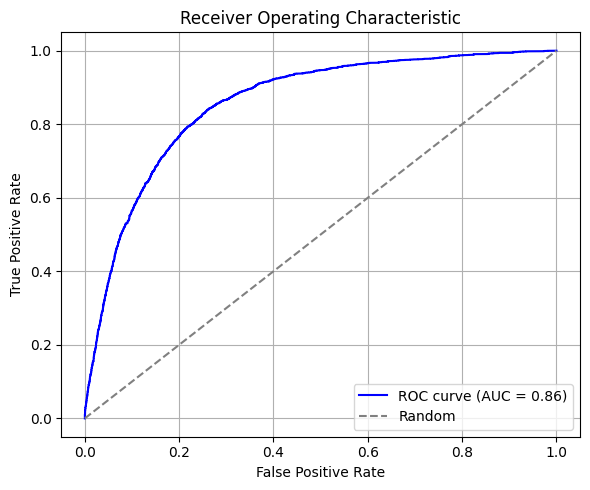

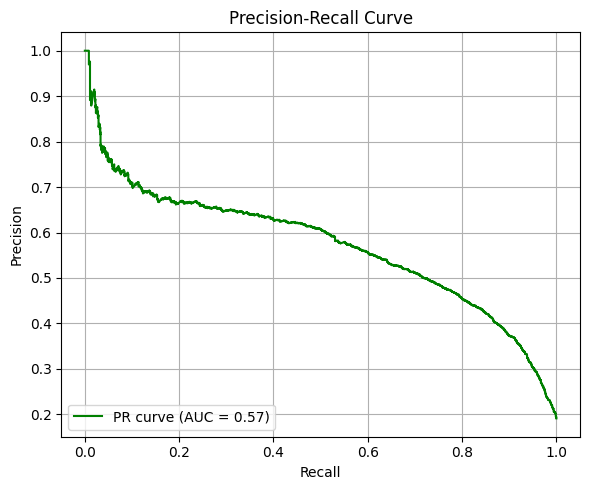

In [9]:
# ROC curve

import matplotlib.pyplot as plt

# get ROC curve points
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# plot PR curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

